In [10]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import keras.layers as layers
from keras.models import Model
from keras.callbacks import ModelCheckpoint

In [11]:
# electrode_names = [
#     "FP1", "FPz", "FP2", "AFp1", "AFPz", "AFp2", "AF7", "AF3", "AF4", "AF8",
#     "AFF5h", "AFF1h", "AFF2h", "AFF6h", "F9", "F7", "F5", "F3", "F1", "Fz",
#     "F2", "F4", "F6", "F8", "F10", "FFT9h", "FFT7h", "FFC5h", "FFC3h", "FFC1h",
#     "FFC2h", "FFC4h", "FFC6h", "FFT8h", "FFT10h", "FT9", "FT7", "FC5", "FC3",
#     "FC1", "FCz", "FC2", "FC4", "FC6", "FT8", "FT10", "FTT9h", "FTT7h", "FCC5h",
#     "FCC3h", "FCC1h", "FCC2h", "FCC4h", "FCC6h", "FTT8h", "FTT10h", "T7", "C5",
#     "C3", "C1", "Cz", "C2", "C4", "C6", "T8", "TTP7h", "CCP5h", "CCP3h", "CCP1h",
#     "CCP2h", "CCP4h", "CCP6h", "TTP8h", "TP9", "TP7", "CP5", "CP3", "Cpz", "CP4",
#     "CP6", "TP8", "TP10", "TPP9h", "TPP7h", "CPP5h", "CPP3h", "CPP1h", "CPP2h",
#     "CPP4h", "CPP6h", "TPP8h", "TPP10h", "P9", "P7", "P5", "P3", "P1", "Pz", "P2",
#     "P4", "P6", "P8", "P10", "PPO9h", "PPO5h", "PPO1h", "PPO2h", "PPO6h", "PPO10h",
#     "PO9", "PO7", "PO3", "POz", "PO4", "PO8", "PO10", "POO9h", "POO1", "POO2",
#     "POO10h", "O1", "Oz", "O2", "OI1h", "OI2h", "I1", "Iz", "I2"
# ]

# num_electrodes = len(electrode_names)

NUM_CHANNELS_TO_LOAD = 128
DATA_SIZE = 60_000
SIGNAL_LENGTH = 167
BATCH_SIZE = 128

In [12]:
def load_in_order(cz: int):
    dataset = np.zeros((DATA_SIZE, NUM_CHANNELS_TO_LOAD, SIGNAL_LENGTH), dtype=np.int32)
    labels = np.zeros(DATA_SIZE, dtype=np.int8)
    
    i = 0
#     j = 0
    for chunk in tqdm(pd.read_csv('/kaggle/input/processed-train/processed_train.csv', chunksize=cz)):
        chunk = chunk[chunk['label'] != -1]
        l = chunk['label'].to_numpy()
#         print(l[0:10])
#         print(l)
#         mask = (l % 2 == 0)
#         mask = l == -1
#         print(mask)
#         l = np.where(mask, 0, 1)
        o = chunk.shape[0]
        labels[i:i+o] = l
#         d = chunk.iloc[:, :-2].to_numpy().reshape(-1, 128, SIGNAL_LENGTH)
#         dataset[i:i+o] = d[:,[1,23,33,36,37,39,46,54],:]
        dataset[i:i+o] = chunk.iloc[:, :-2].to_numpy().reshape(-1, 128, SIGNAL_LENGTH)
#         del d
#         j += 1
#         if j == 2:
#             break
        
        i += o
#         break
    labels = labels[:i]
    dataset = dataset[:i]
    return labels, dataset
        

labels, datasets = load_in_order(1_000)
print(labels[0:10])
np.random.shuffle(labels)
print(labels[0:10])


61it [11:22, 11.19s/it]

[5 0 4 1 9 2 1 3 1 4]
[9 1 5 8 8 3 1 1 2 3]


In [13]:
import gc
gc.collect()
# del train
# del test
# del train_y
# del test_y
# gc.collect()
# gc.collect()
print(labels)

[9 1 5 ... 7 4 8]


In [14]:
# from keras.utils import to_categorical
# labels = labels.reshape(-1, 1)
# print(labels.shape)
# print(labels[0:10])
# labels = to_categorical(labels, num_classes=2)


In [15]:
from keras import regularizers

from tensorflow.keras import layers
import tensorflow as tf

input_data = layers.Input((NUM_CHANNELS_TO_LOAD, SIGNAL_LENGTH))
x = layers.Rescaling(1/30000)(input_data)
x = layers.Conv1D(64, 16, activation='relu', data_format='channels_first')(x)
# x = layers.SpatialDropout1D(0.5)(x)
# x = layers.BatchNormalization()(x)
# # x = layers.MaxPooling1D()(x)
# x = layers.Conv1DTranspose(64, 128, activation='relu', data_format='channels_first')(x)
# # x = layers.SpatialDropout1D(0.5)(x)
# x = layers.BatchNormalization()(x)
# # x = layers.MaxPooling1D()(x)
# x = layers.Conv1D(128, 16, activation='relu', data_format='channels_first')(x)
# # x = layers.SpatialDropout1D(0.75)(x)
# x = layers.BatchNormalization()(x)
# x = layers.MaxPooling1D()(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation = 'relu')(x)
x = layers.Dense(10, activation='softmax')(x)
model = Model(input_data, x)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.save_weights('/kaggle/working/best_model.weights.h5')
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 167)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 128, 167)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 64, 152)        │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9728)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │     2,490,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,624,330 (10.01 MB)

 Trainable params: 2,624,330 (10.01 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# del history
# del model
gc.collect()
# vars()


13

In [17]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
train, test, train_y, test_y = train_test_split(datasets, labels, test_size=0.2, random_state=42, shuffle=True)
history = model.fit(train, train_y, validation_data=(test, test_y), batch_size=128, epochs=100)

Epoch 1/100
 22/375 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.0839 - loss: 3.2643

W0000 00:00:1715004765.308590     103 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


370/375 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1036 - loss: 2.4536

W0000 00:00:1715004769.783841     101 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - accuracy: 0.1037 - loss: 2.4518 - val_accuracy: 0.1113 - val_loss: 2.3017
Epoch 2/100
 13/375 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.1275 - loss: 2.3029

W0000 00:00:1715004771.741629     104 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1136 - loss: 2.3020 - val_accuracy: 0.1117 - val_loss: 2.3010
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1129 - loss: 2.3016 - val_accuracy: 0.1114 - val_loss: 2.3054
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1119 - loss: 2.3021 - val_accuracy: 0.1117 - val_loss: 2.3009
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1105 - loss: 2.3017 - val_accuracy: 0.1117 - val_loss: 2.3010
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1126 - loss: 2.3013 - val_accuracy: 0.1117 - val_loss: 2.3011
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1114 - loss: 2.3014 - val_accuracy: 0.1117 - val_loss: 2.3011
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.1161 - loss: 2.3010 - val_accuracy: 0.1117 - val_loss: 2.3010
Epoch 9/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.1120 - loss: 2.3014 - val_accuracy: 0.1117

Text(0.5, 1.0, 'Loss during Training')

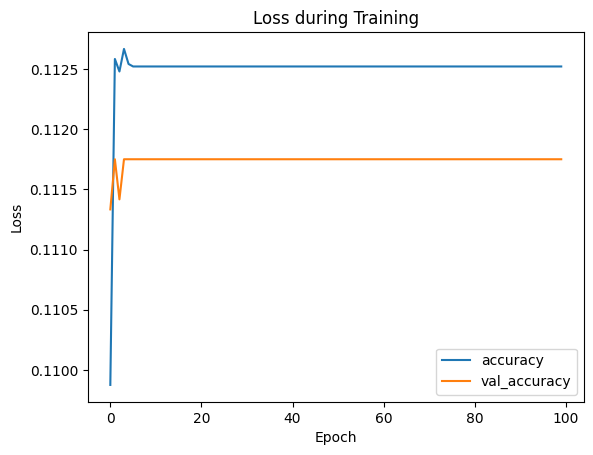

In [18]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss during Training")